In [1]:
from matplotlib.gridspec import GridSpec
from astropy.io import fits
import sys
import os
#sys.path.append(os.path.abspath(os.path.join('.'))+"\\ICA Scripts")
sys.path.append(os.path.abspath(os.path.join("ICA Scripts")))
#sys.path.append("/Users/trevormccaffrey/Dropbox/ICA_module/code_main/")
#sys.path.append("/Users/Trevor1/Dropbox/ICA_module/")
import run_ICA_r20_components
#sys.path.append("/Users/trevormccaffrey/Dropbox/HST/HSTCode/")
import Read_spec_data #
import Cut_Edge_Pix_TVM #
import Small_Pix_Filter_TVM
import spec_morph
import plot_ICA
import matplotlib
import matplotlib.pyplot as plt
#import richardsplot as rplot
import numpy as np
import weightedstats as ws
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')
# %load_ext autoreload
# %autoreload 2

In [2]:
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True

In [3]:
%%capture

def arg2min(arr):
    #return index of second closest point
    return np.argsort(arr)[1]

def blueshift(wave_half_flux):
    return ((1549.48 - wave_half_flux) / 1549.48) * 3e5

def get_CIV(wave, flux, wave_r, flux_r, name, ax=plt.gca(), EW_region=[1500,1600], cont_region=[[1445,1465],[1700,1705]]):
    #print("Getting CIV")
    #Going to save plots, but not show with magic above
    #"""
    ylow, yup = max(0, np.percentile(flux_r, 1)-np.nanmedian(flux_r)/5), np.percentile(flux_r, 99)+np.nanpercentile(flux_r, 95)
    #fig, ax = plt.subplots(figsize=(9,9))
    #fig = plt.figure(figsize=(9,9))
    ax.plot(wave, flux, "-k", alpha=0.5)#, label="HST co-add")
    ax.plot(wave_r, flux_r, "-r", lw=2.2)#, label="ICA fit")
    ax.plot([1549.48,1549.48], [ylow,yup], "--k", label="CIV Rest Wavelength")
    #"""
    
    #Fit continuum -- ADD MANUAL HERE
    cont1 = ((wave_r>=cont_region[0][0])&(wave_r<=cont_region[0][1]))
    cont2 = ((wave_r>=cont_region[1][0])&(wave_r<=cont_region[1][1]))
    ax.axvspan(cont_region[0][0], cont_region[0][1], alpha=0.5, color='grey')
    ax.axvspan(cont_region[1][0], cont_region[1][1], alpha=0.5, color='grey')

    m,b = np.polyfit(np.concatenate((wave_r[cont1], wave_r[cont2])), np.concatenate((flux_r[cont1], flux_r[cont2])), 1)
    continuum = wave_r*m + b
    ax.plot(wave_r, continuum, "-m")
    
    #Plot EW region under flux_r -- ADD MANUAL HERE
    EW = ((wave_r>=EW_region[0])&(wave_r<=EW_region[1]))

    #And compute the EW
    CIV_EW = 0
    ew_list = [0.]
    for i in range(len(wave_r[EW])):
        try:
            CIV_EW += max(( (flux_r[EW][i] - continuum[i]) / continuum[i] ) * ( wave_r[EW][i+1] - wave_r[EW][i] ), 0) #no absorption
        except IndexError:
            CIV_EW += max(( (flux_r[EW][i] - continuum[i]) / continuum[i] ) * ( wave_r[EW][i] - wave_r[EW][i-1] ), 0)

        ew_list.append(CIV_EW)

    ax.fill_between(wave_r[EW], continuum[EW], flux_r[EW], color="blue", alpha=0.2, label="Equivalent Width = %.1f Å"%CIV_EW)

    ind_half_flux = abs((CIV_EW / 2) - np.array(ew_list)).argmin()
    CIV_blue = blueshift(wave_r[EW][ind_half_flux])
    #"""  
    #for w in np.arange(1450,1530,10): ax.plot([w,w],[ylow,yup],"--",label=str(w))
    #for w in np.arange(1610,1640,10): ax.plot([w,w],[ylow,yup],"--",label=str(w))
    ax.plot([EW_region[0],EW_region[0]], [ylow,yup], "-b", alpha=0.7)
    ax.plot([EW_region[1],EW_region[1]], [ylow,yup], "-b", alpha=0.7)
    ax.plot([wave_r[EW][ind_half_flux],wave_r[EW][ind_half_flux]], [ylow,yup], "--b", label="Blueshift = %.1f km/s" % (CIV_blue))
    ax.set_xlim(1435, 1710)
    ax.set_ylim(ylow, yup)
    ax.set_xlabel("Rest-frame Wavelength (Å)", fontsize=20)
    #ax.set_ylabel("Flux (Arbitrary Units)", fontsize=20)
    #ax.set_title("Blue, EW = %.2f km/s, %.2f Å" % (CIV_blue,CIV_EW), fontsize=20)
    ax.set_title(name, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=17.5)
    ax.tick_params(axis='both', which='minor', labelsize=17.5)
    ax.tick_params(labelleft=False)
    #ax.legend(loc="best", prop={"size":15})
    #plt.tight_layout()
    #"""    
    return CIV_blue, CIV_EW

The above cell prepares the functions needed for the ICA/CIV plots

In [23]:
!ls ../Sulentic_spectra/SulenticAllData/FOS/J09270+3902/y0pe0702t

y0pe0702t_c0f.fits y0pe0702t_c1f.fits y0pe0702t_c2f.fits y0pe0702t_cqf.fits


In [15]:
!pwd ..

/Users/trevormccaffrey/Dropbox/HST/Notebooks_final_MarchApril2023


In [4]:
path_obj = ""
name_obj = "J09270+3902"

spec_list_alex = pd.read_csv("%s%s/NecessaryParams.csv"%(path_obj,name_obj))["obs_id"].values
spec_list_alex

array(['y0pe0702t', 'y0pe0703t', 'y0pe0704t', 'y1170102t', 'y1170103t',
       'y1170104t'], dtype=object)

This is my preparation of the file paths needed to run the analysis. My goal is to remove any local path names and have it so that a user can create these plots if they have all the necessary files downloaded (e.g.  without needed to change any path names).  

In [33]:
path_obj = "/Users/trevormccaffrey/Dropbox/HST/Sulentic_spectra/SulenticAllData/FOS/"
name_obj = "J09270+3902"

In [42]:
spec_list = pd.read_csv("%s%s/NecessaryParams.csv"%(path_obj,name_obj))["obs_id"].values
spec_list

array(['y0pe0702t', 'y0pe0703t', 'y0pe0704t', 'y1170102t', 'y1170103t',
       'y1170104t'], dtype=object)

NecessaryParams contains two columns: filters and obs_id. The filters are the different gratings and obs id are strings such as those above

In [5]:
zem = 0.6953

Redshift of the quasar set by hand. Will create a helper function to grab this data automatically from HST_CIV_Sulentic2007_HSLA2015.csv

In [6]:
hst_waves, hst_fluxes, hst_errors, hst_masks = Read_spec_data.read_data("J09270+3902", path_obj, "FOS", zem)

Read_spec_data does a lot of heavy lifting in terms of preparing the data.  
Returns the 2D arrays of HST waves, fluxes, errors, and masks.  
For this example, each obs_id returns a 2D array for wavelengths, fluxes, errors, and masks. The read_data method collapses these into a 1D array and applies masks to bad data. 

In [7]:
maskBad = (hst_waves/(1+zem))>2500 #cut HST exposures covering half of MgII, use SDSS
hst_waves[maskBad] = 0
hst_fluxes[maskBad] = np.nan
hst_errors[maskBad] = np.nan
hst_masks[maskBad] = 0

In [8]:
Nexp = hst_waves.shape[0]+1

In [9]:
#sdss_spec = fits.open("/Users/trevormccaffrey/Dropbox/HST/Sulentic_spectra/SulenticAllData/SDSS/lite/8832/spec-8832-57445-0384.fits")
sdss_spec = fits.open("spec-8832-57445-0384.fits")
sdss_wave = 10.**sdss_spec[1].data["LOGLAM"]
sdss_flux = sdss_spec[1].data["FLUX"]*1e-17
sdss_errs = 1 / np.sqrt(sdss_spec[1].data["IVAR"]) * 1e-17
sdss_mask = sdss_spec[1].data["AND_MASK"]

retrieves the SDSS data for the specified object - in order to generalize this, will need to make a helper funciton to retrieve SDSS plate numbering for specific object, will use the HST/Sulentic_Spectra/Sulentic2007info_wpaths or HST_CIV_Sulentic2007_HSLA2015 csv file

In [10]:
arrlen = max(len(sdss_wave), hst_waves.shape[1])

waves  = np.zeros((Nexp, arrlen))
fluxes = np.zeros((Nexp, arrlen))*np.nan
errors = np.zeros((Nexp, arrlen))*np.nan
masks  = np.zeros((Nexp, arrlen))

Creates an array where the number of rows is the number of exposures (the first Nexp-1 rows are for HST data, last row for SDSS data) and the number of columns is the max wavelength coverage of SDSS and HST.

In [11]:
len(hst_waves)

6

In [12]:
waves[:Nexp-1,:hst_waves.shape[1]] = hst_waves
fluxes[:Nexp-1,:hst_waves.shape[1]] = hst_fluxes
errors[:Nexp-1,:hst_waves.shape[1]] = hst_errors
masks[:Nexp-1,:hst_waves.shape[1]] = hst_masks

Loads the HST data into the first Nexp-1 rows

In [13]:
waves[Nexp-1,:len(sdss_wave)]  = sdss_wave
fluxes[Nexp-1,:len(sdss_wave)] = sdss_flux
errors[Nexp-1,:len(sdss_wave)] = sdss_errs * 15
masks[Nexp-1,:len(sdss_wave)]  = sdss_mask

Loads the SDSS data into the last row

In [14]:
wave_low  = np.nanmin(waves[waves!=0])
wave_high = np.nanmax(waves[waves!=0])

In [15]:
loglam_temp       = np.arange(np.log10(wave_low), np.log10(wave_high), 0.0001)
loglam_temp_edges = loglam_temp - 0.0001/2
loglam_temp_edges = np.append(loglam_temp_edges, loglam_temp[-1]+0.0001/2)

In [16]:
10.**loglam_temp

array([ 1697.17419434,  1697.56502813,  1697.95595193, ...,
       10323.48710557, 10325.86445001, 10328.24234192])

In [17]:
loglam_orig = np.log10(waves)

The three cells above prepare the rebinning. Everything will be binned into an array of equally spaced wavelengths in log space. 

In [18]:
loglam_rebin = np.array(Nexp*[loglam_temp])
fluxes_rebin = np.nan*np.zeros((Nexp, len(loglam_temp)))
errors_rebin = np.nan*np.zeros((Nexp, len(loglam_temp)))
masks_rebin  = np.zeros((Nexp, len(loglam_temp)))

#and fill them in
for k in range(Nexp):
    for i in range(len(loglam_temp_edges)-1):
        ledge_rebin, redge_rebin = loglam_temp_edges[i], loglam_temp_edges[i+1]
        #orig edges
        #oldwidth =

        maskOrig = (loglam_orig[k,:]>ledge_rebin)&(loglam_orig[k,:]<redge_rebin) #obtains the indeces for each data type (flux/error/mask) that fits into each bin - AP
        if not maskOrig.sum()==0:
            #flux_rebin[i] = ws.numpy_weighted_median(flux[maskOrig], weights=1./(errs[maskOrig]**2))
            
            fluxes_rebin[k,i] = np.nanmedian(fluxes[k,maskOrig])
            errors_rebin[k,i] = np.nanmedian(errors[k,maskOrig])
            masks_rebin[k,i]  = np.nanmax(masks[k,maskOrig])

            #Much of the rebinning seems to get done here. MaskOrig finds the pixels in the original wave/flux/errors/mask arrays that fall into a 
            #wavelength bin in the log rebin space, then takes the median of these values in order to perform the rebinning. AP

    loglam_low_orig  = min(np.log10(waves[k,waves[k,:]!=0])) # Log_10 of  minimum value of the wavelength array in row k (remove zeros first) - AP
    loglam_high_orig = max(np.log10(waves[k,waves[k,:]!=0])) # Same but for max
    if (np.isnan(fluxes_rebin[k,:])).any():
        #initial resolution could be low enough such that some re-binned pixels weren't assigned a value
        #for those, interpolate with nearest neighbors -TVM
        for j in range(len(fluxes_rebin[k,:])):
            WAVE_IN_SPEC_NOT_TEMP = (loglam_rebin[k,j]>loglam_low_orig)&(loglam_rebin[k,j]<loglam_high_orig)
            if np.isnan(fluxes_rebin[k,j]) and WAVE_IN_SPEC_NOT_TEMP: #should make sure here it's not a known "gap", instead just ones missed from above
                #Not sure what Trevor means by the above line, what would constitute a "known" gap?
                
                #arg1 = np.argmin(loglam_rebin[~np.isnan(flux_rebin)]-logwave[j])
                arg1 = np.argmin(np.abs(loglam_rebin[k,~np.isnan(fluxes_rebin[k,:])]-loglam_rebin[k,j]))
                arg2 = arg2min(np.abs(loglam_rebin[k,~np.isnan(fluxes_rebin[k,:])]-loglam_rebin[k,j]))
                #print(10.**loglam_rebin[arg1], 10.**loglam_rebin[arg2])
                loglam1, flux1, errs1 = loglam_rebin[k,~np.isnan(fluxes_rebin[k,:])][arg1], \
                                        fluxes_rebin[k,~np.isnan(fluxes_rebin[k,:])][arg1], \
                                        errors_rebin[k,~np.isnan(fluxes_rebin[k,:])][arg1]
                loglam2, flux2, errs2 = loglam_rebin[k,~np.isnan(fluxes_rebin[k,:])][arg2], \
                                        fluxes_rebin[k,~np.isnan(fluxes_rebin[k,:])][arg2], \
                                        errors_rebin[k,~np.isnan(fluxes_rebin[k,:])][arg2]
                oldwidth = abs(loglam2-loglam1)
                #do linear fit on nearest non-nan neighbors
                m_flux, b_flux = np.polyfit([loglam1, loglam2], [flux1, flux2], 1)
                fluxes_rebin[k,j] = m_flux*loglam_rebin[k,j] + b_flux
                m_errs, b_errs = np.polyfit([loglam1, loglam2], [errs1, errs2], 1)
                errors_rebin[k,j] = (m_errs*loglam_rebin[k,j] + b_errs) #* np.sqrt(oldwidth/0.0001)
                #leave mask[j]==0 for now

    #wave_rebin = 10.**loglam_rebin
    #errs_rebin *= error_multiple
    #flux_rebin[flux_rebin==0] = np.nan
    #errs_rebin[flux_rebin==0] = 0

This cell does all the rebinning, could be made refactored into its own function as it relies on no external code? 

Rebinning occurs by uniformly distributing the wavelengths in log space, then putting the data into each wavelength "bin". When multiple data points fit into the same bin, the median is taken for the data (eg median flux, error, or mask). Is this the correct "scientific" practice and why?

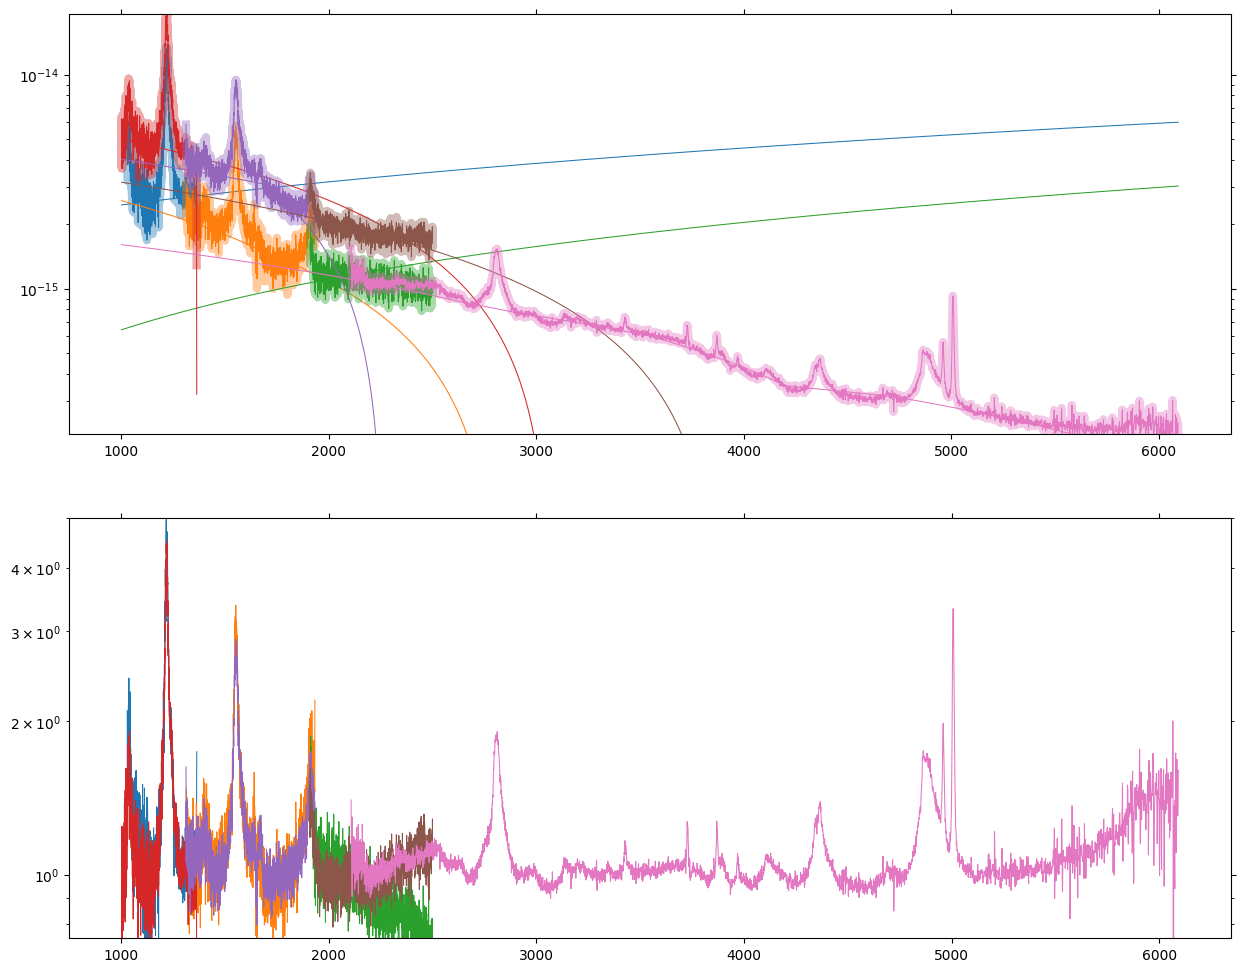

In [21]:
fluxes_rebin_contnorm = fluxes_rebin.copy()
errors_rebin_contnorm = errors_rebin.copy()

fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(15,12))
ylow, yup = np.nanpercentile(fluxes_rebin, [0.5,99.9])
for i in range(Nexp):
    p = ax1.plot(waves[i,:]/(1+zem), fluxes[i,:], alpha=0.4, lw=6)
    ax1.plot(10.**loglam_rebin[i,:]/(1+zem), fluxes_rebin[i,:], color=p[0].get_color(), lw=0.75)
    
    #continuum = spec_morph.cont_filtered(10.**loglam_rebin[i,:], fluxes_rebin[i,:], zem, "Identifier")
    continuum = spec_morph.continuum_fit(10.**loglam_rebin[i,:], fluxes_rebin[i,:], zem)
    ax1.plot(10.**loglam_rebin[i,:]/(1+zem), continuum, color=p[0].get_color(), lw=0.75)
    ax2.plot(10.**loglam_rebin[i,:]/(1+zem), fluxes_rebin[i,:]/continuum, color=p[0].get_color(), lw=0.75)
    fluxes_rebin_contnorm[i,:] = fluxes_rebin[i,:] / continuum
    errors_rebin_contnorm[i,:] = errors_rebin[i,:] / continuum
    
#do SDSS now
#spec_continuum = spec_morph.continuum_fit2(spec_wave, spec_flux, zem)
#ax1.plot(spec_wave/(1+zem), spec_flux, "-b")
#ax2.plot(spec_wave/(1+zem), spec_flux/spec_continuum, "-b")
    
ax1.set_ylim(ylow, yup)
#ax1.set_ylim(5e-16,2.5e-15)
ax2.set_ylim(0.75,5)
#ax1.set_xlim(2250,None)
ax1.set_yscale("log")
ax2.set_yscale("log")
plt.show()

The plot above is my recreation of Trevor's figure 2 in the draft paper. The top plot contains each spectrum as...

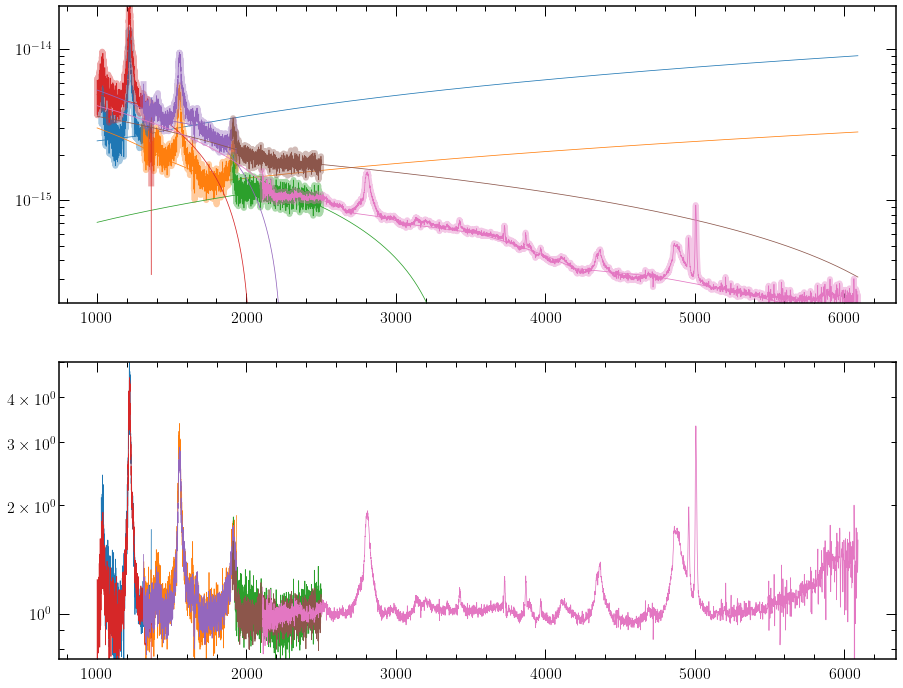

In [473]:
fluxes_rebin_contnorm = fluxes_rebin.copy()
errors_rebin_contnorm = errors_rebin.copy()

fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(15,12))
ylow, yup = np.nanpercentile(fluxes_rebin, [0.5,99.9])
for i in range(Nexp):
    p = ax1.plot(waves[i,:]/(1+zem), fluxes[i,:], alpha=0.4, lw=6)
    ax1.plot(10.**loglam_rebin[i,:]/(1+zem), fluxes_rebin[i,:], color=p[0].get_color(), lw=0.75)
    
    #continuum = spec_morph.cont_filtered(10.**loglam_rebin[i,:], fluxes_rebin[i,:], zem, "Identifier")
    continuum = spec_morph.continuum_fit(10.**loglam_rebin[i,:], fluxes_rebin[i,:], zem)
    ax1.plot(10.**loglam_rebin[i,:]/(1+zem), continuum, color=p[0].get_color(), lw=0.75)
    ax2.plot(10.**loglam_rebin[i,:]/(1+zem), fluxes_rebin[i,:]/continuum, color=p[0].get_color(), lw=0.75)
    fluxes_rebin_contnorm[i,:] = fluxes_rebin[i,:] / continuum
    errors_rebin_contnorm[i,:] = errors_rebin[i,:] / continuum
    
#do SDSS now
#spec_continuum = spec_morph.continuum_fit2(spec_wave, spec_flux, zem)
#ax1.plot(spec_wave/(1+zem), spec_flux, "-b")
#ax2.plot(spec_wave/(1+zem), spec_flux/spec_continuum, "-b")
    
ax1.set_ylim(ylow, yup)
#ax1.set_ylim(5e-16,2.5e-15)
ax2.set_ylim(0.75,5)
#ax1.set_xlim(2250,None)
ax1.set_yscale("log")
ax2.set_yscale("log")
plt.show()

Now do the coadd - TVM

In [23]:
coadd_wave = 10.**loglam_temp.copy()
coadd_flux = np.zeros(len(coadd_wave))*np.nan
coadd_errs = np.zeros(len(coadd_wave))*np.nan
coadd_mask = np.zeros(len(coadd_wave))

Prepares the arrays to fill with coadd products

In [24]:
total_variance = np.nansum(errors_rebin, axis=0)

In [25]:
weights = 1 / (errors_rebin / total_variance)

Inverse Variance Weighting?

In [26]:
weights[(np.isnan(weights))|(np.isinf(weights))] = 0

Sets all bad weights to 0

In [27]:
np.isinf(weights).any()

False

In [28]:
for i in range(len(coadd_wave)):
    coadd_flux[i] = ws.numpy_weighted_median(fluxes_rebin_contnorm[:,i], weights=weights[:,i])
    coadd_errs[i] = ws.numpy_weighted_median(errors_rebin_contnorm[:,i], weights=weights[:,i])
    coadd_mask[i] = np.nanmin(masks_rebin[:,i])

To do the actual coadd, take the weighted median of the fluxes and errors. Why is this better than taking weighted average? (because it is more resistant to outliers?)

In [29]:
coadd_flux

array([1.24359713, 1.04443869, 1.1252029 , ..., 1.30314131, 1.38010782,
       1.60111429])

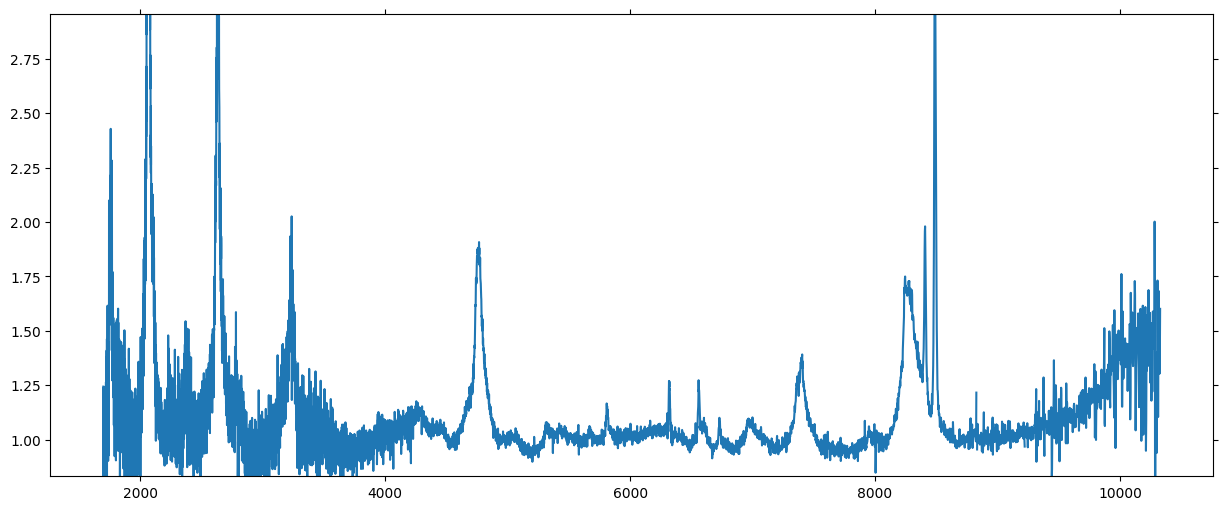

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.plot(coadd_wave, coadd_flux)
ax.set_ylim(np.nanpercentile(coadd_flux, [1,99]))
plt.show()

Plot of the coadd, 1st to 99th percentile of flux. 

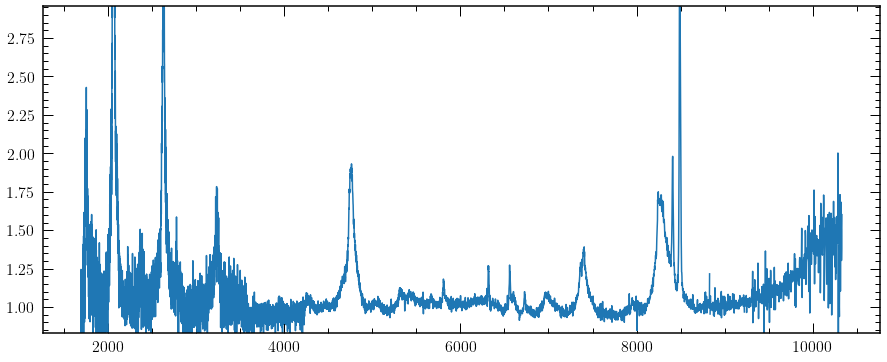

In [481]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.plot(coadd_wave, coadd_flux)
ax.set_ylim(np.nanpercentile(coadd_flux, [1,99]))
plt.show()

In [31]:
wave_arb, flux_arb, errs_arb, mask_arb, wave_ica, flux_ica, f2500_ica = \
run_ICA_r20_components.main_ICA(coadd_wave/(1+zem), coadd_flux, coadd_errs, coadd_mask, zem, name="", 
                                ica_path="./")

./c3_priors/MattS_CIV_tplte\mc_00000500_hew500.fits
./c3_priors/MattS_CIV_tplte\mc_00000500_lew500.fits
./c3_priors/MattS_CIV_tplte\mc_00000500_lew500p1.fits
./c3_priors/MattS_CIV_tplte\mc_00000500_lew500p2.fits
./c3_priors/MattS_CIV_tplte\mc_00000500_lew500p3.fits
./c3_priors/MattS_CIV_tplte\mc_00000500_lew500p4.fits
./c3_priors/MattS_CIV_tplte\mc_05001000_hew500.fits
./c3_priors/MattS_CIV_tplte\mc_05001000_lew500.fits
./c3_priors/MattS_CIV_tplte\mc_05001000_lew500p1.fits
./c3_priors/MattS_CIV_tplte\mc_05001000_lew500p2.fits
./c3_priors/MattS_CIV_tplte\mc_05001000_lew500p3.fits
./c3_priors/MattS_CIV_tplte\mc_05001000_lew500p4.fits
./c3_priors/MattS_CIV_tplte\mc_10001500_hew500.fits
./c3_priors/MattS_CIV_tplte\mc_10001500_lew500.fits
./c3_priors/MattS_CIV_tplte\mc_10001500_lew500p1.fits
./c3_priors/MattS_CIV_tplte\mc_10001500_lew500p2.fits
./c3_priors/MattS_CIV_tplte\mc_10001500_lew500p3.fits
./c3_priors/MattS_CIV_tplte\mc_15002000_hew500.fits
./c3_priors/MattS_CIV_tplte\mc_15002000_le

Calculate the ICA fit, have already separately analyzed this code ove the summer. 

In [482]:
wave_arb, flux_arb, errs_arb, mask_arb, wave_ica, flux_ica, f2500_ica = \
run_ICA_r20_components.main_ICA(coadd_wave/(1+zem), coadd_flux, coadd_errs, coadd_mask, zem, name="", 
                                ica_path="/Users/trevormccaffrey/Dropbox/ICA_module/components/")

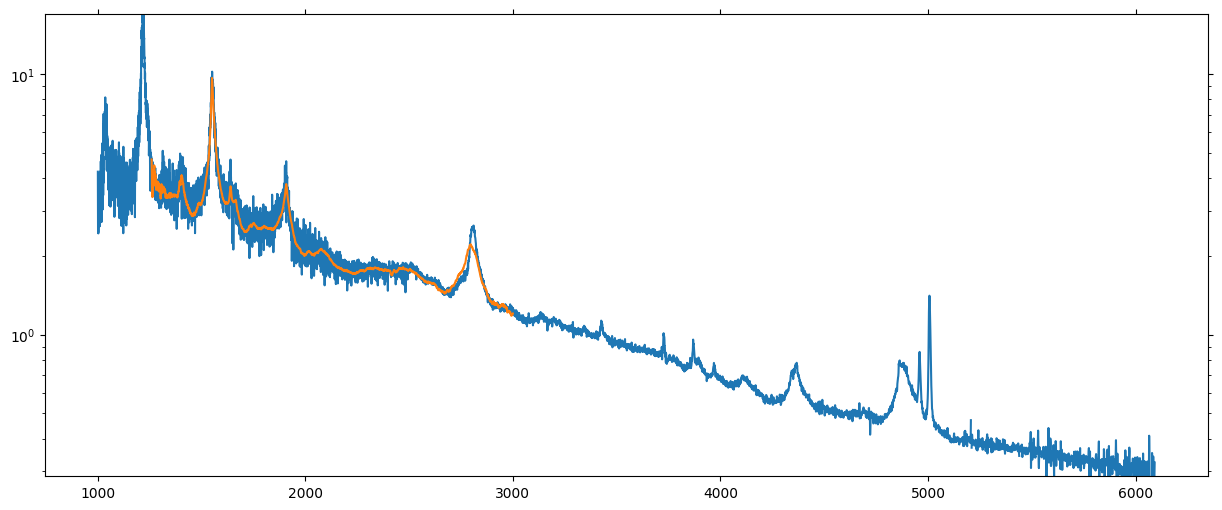

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.plot(wave_arb, flux_arb)
ax.plot(wave_ica, flux_ica)
ax.set_ylim(np.nanpercentile(flux_arb, [.7,99.9]))
ax.set_yscale("log")
plt.show()

The coadd has now been normalized to the continuum. The ICA fit is plotted overtop it. Even though ICA fit only runs until 3000 angstroms, it incorporates the correlation between emmission lines from higher wavelength ranges. 

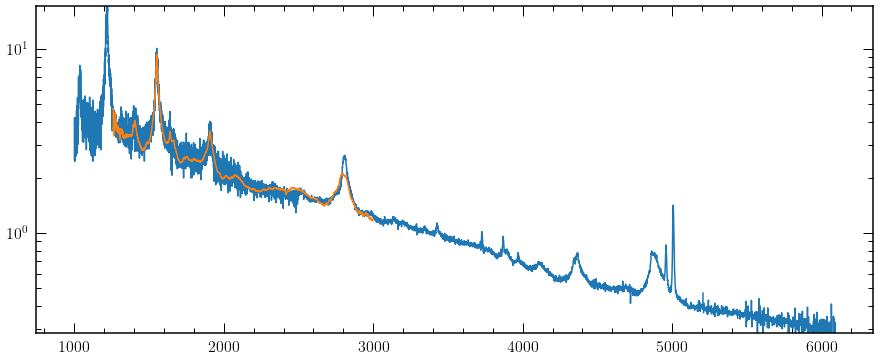

In [483]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.plot(wave_arb, flux_arb)
ax.plot(wave_ica, flux_ica)
ax.set_ylim(np.nanpercentile(flux_arb, [.7,99.9]))
ax.set_yscale("log")
plt.show()

In [33]:
def plot_wmask(ax, wave, flux, mask):
    iplot_start = 0
    #iplot_end   = 0
    mask_curr   = mask_arb[0]
    for i in range(len(wave_arb)):
        #go until mask is a different value
        if mask_arb[i]!=mask_curr or i==len(wave_arb)-1:
            if mask_curr==3:
                #plot BAL region
                ax.plot(wave_arb[iplot_start:i], flux_arb[iplot_start:i], "-m", zorder=2)
            elif mask_curr==2:
                #plot NAL region
                ax.plot(wave_arb[iplot_start:i], flux_arb[iplot_start:i], "-y", zorder=2)
            elif mask_curr==1:
                #plot badpix region
                ax.plot(wave_arb[iplot_start:i], flux_arb[iplot_start:i], "-r", zorder=2)
            else:
                #plot BAL region
                ax.plot(wave_arb[iplot_start:i], flux_arb[iplot_start:i], "-k", zorder=1)

            mask_curr = mask_arb[i]
            iplot_start = i-1

In [35]:
#spec_sdss[1].header

In [36]:
def set_logxticks(ax, wave):
    ticks = np.array([1000,1200,1500,2000,2500,3000,4000,5000,6000,7000,8000])
    ticks_use = ticks[(ticks>np.nanmin(wave))&(ticks<np.nanmax(wave))]
    #ticks_use = ticks[(ticks>min(wave))&(ticks<red_expxlim)]
    ax.set_xticks(ticks_use)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_tick_params(which='minor', size=0)
    ax.get_xaxis().set_tick_params(which='minor', width=0)
    #plt.minorticks_off()

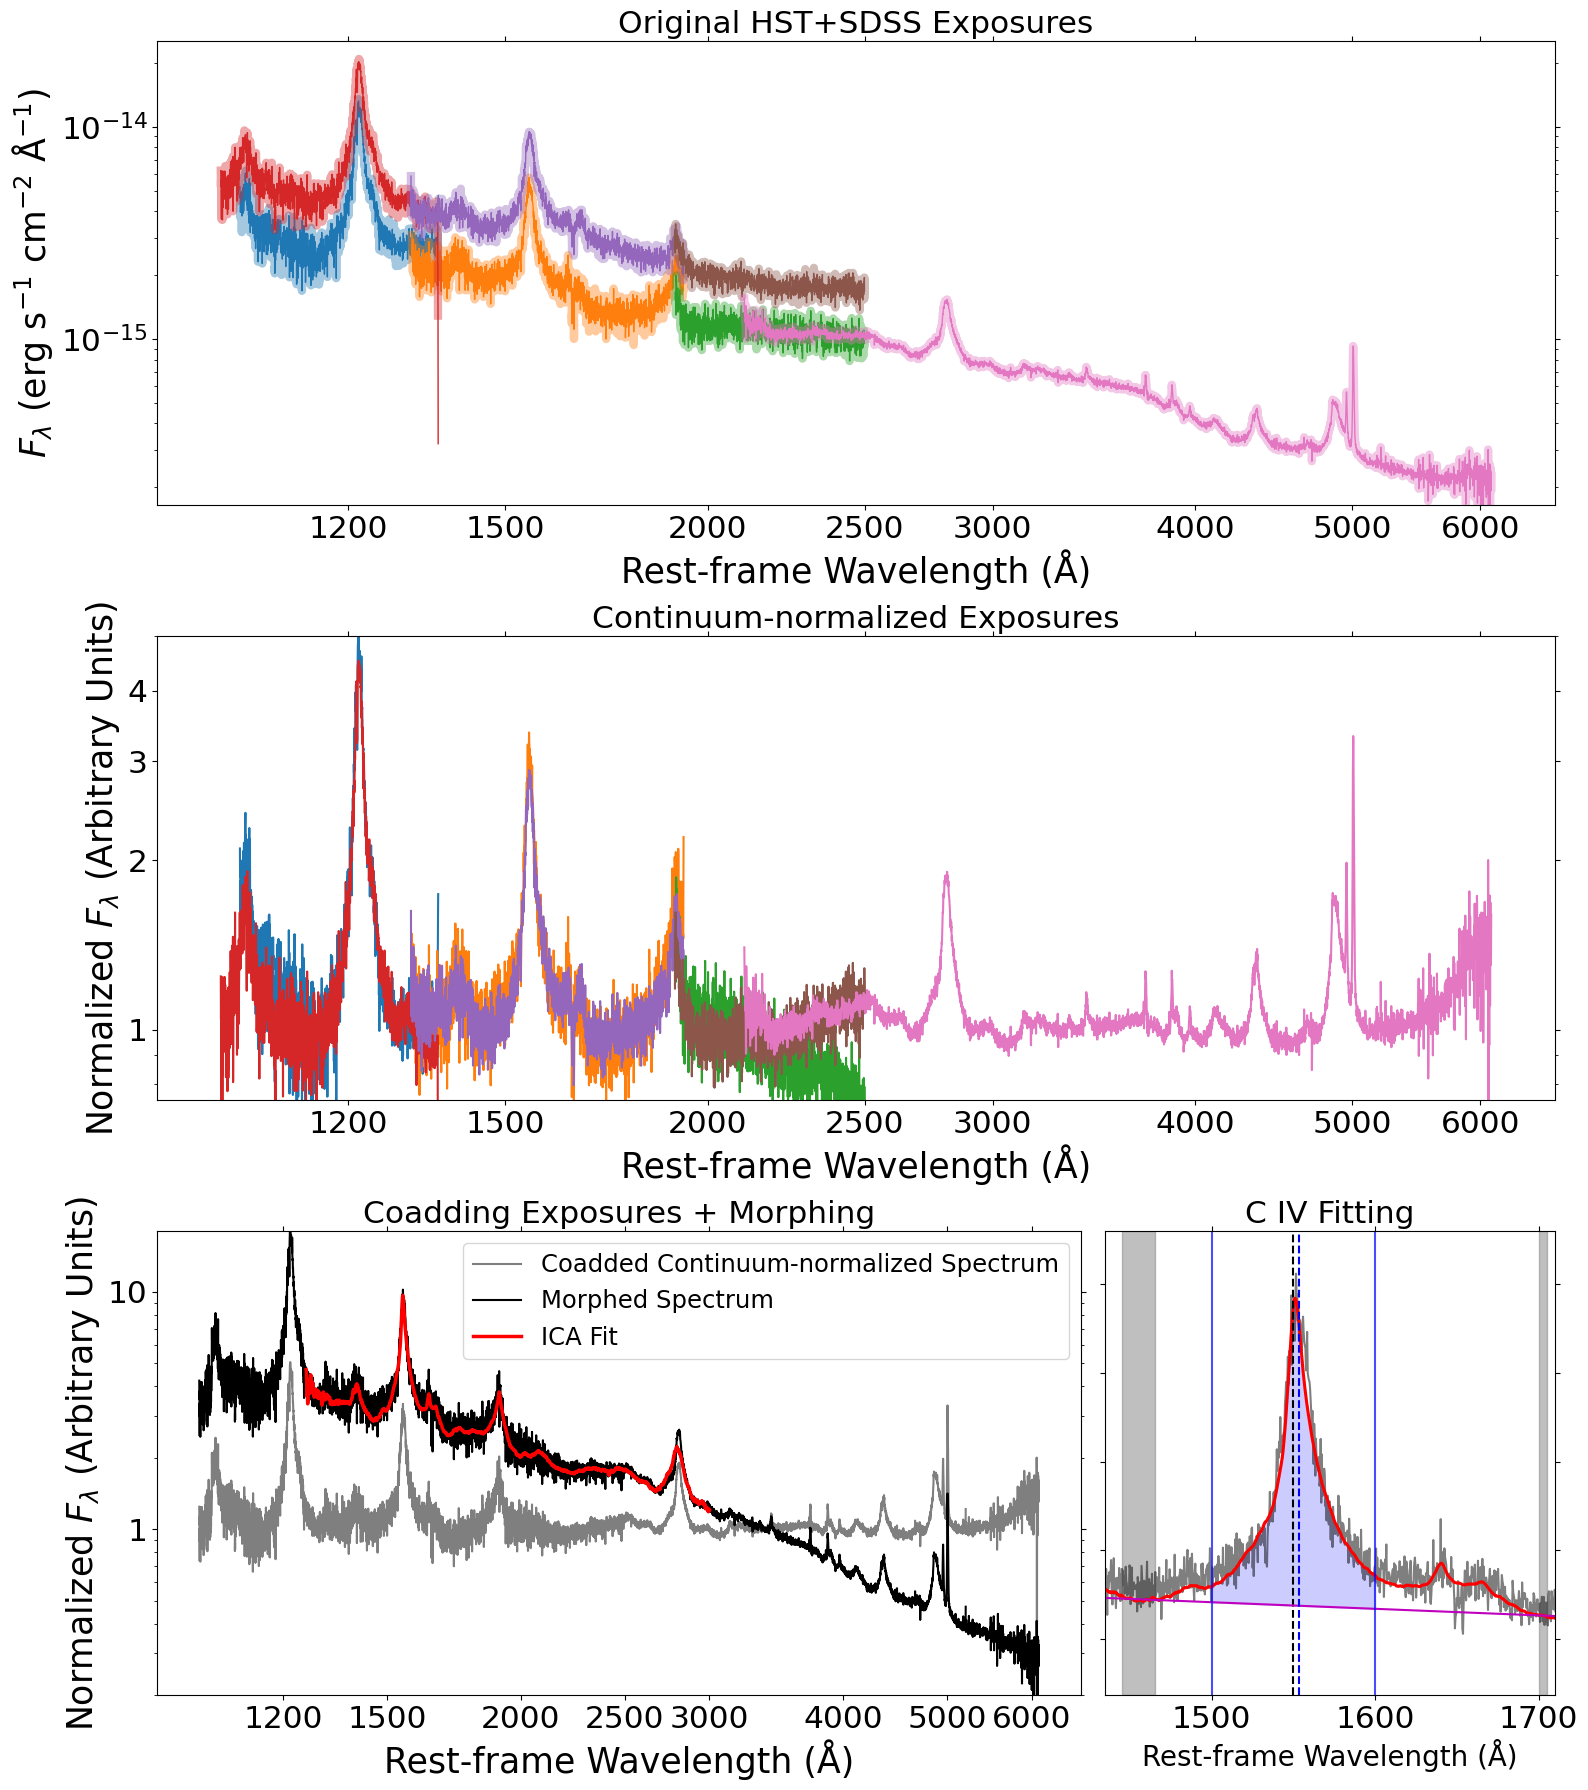

In [40]:
#fig, [axRebin, axNorm, axMorph] = plt.subplots(3, 1, figsize=(16,17))
fig = plt.figure(figsize=(16,18), constrained_layout=True)
gs  = GridSpec(12, 12, figure=fig)
axRebin = fig.add_subplot(gs[:4,:]) #ica reconstruction
axNorm  = fig.add_subplot(gs[4:8,:])   #CIV fitting
axMorph = fig.add_subplot(gs[8:,:8])
axCIV   = fig.add_subplot(gs[8:,8:])
#plt.subplots_adjust(vspace=0)

#do re-bin
ylow, yup = np.nanpercentile(fluxes_rebin, [0.05,100])
for i in range(Nexp):
    p = axRebin.plot(waves[i,:]/(1+zem), fluxes[i,:], alpha=0.4, lw=6)
    axRebin.plot(10.**loglam_rebin[i,:]/(1+zem), fluxes_rebin[i,:], color=p[0].get_color(), lw=1)
    #axRebin.plot(10.**loglam_rebin[i,:]/(1+zem), errors_rebin[i,:], color=p[0].get_color(), lw=0.75)
    axNorm.plot(10.**loglam_rebin[i,:]/(1+zem), fluxes_rebin_contnorm[i,:], color=p[0].get_color())

#axRebin.plot(spec_wave/(1+zem), spec_flux, "-b")
axRebin.set_ylim(ylow, yup+5e-15)
#axRebin.set_ylim(2e-17, yup)
axRebin.set_yscale("log")
axRebin.set_xscale("log")
set_logxticks(axRebin, waves[waves!=0]/(1+zem))
axRebin.set_xlabel("Rest-frame Wavelength (Å)", fontsize=25)
axRebin.set_ylabel(r"$F_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)", fontsize=25)

#axNorm.plot(coadd_wave/(1+zem), coadd_flux, "-k", lw=0.65)
axNorm.set_ylim(0.75,5)
axNorm.set_yscale("log")
axNorm.set_yticks([1,2,3,4])
axNorm.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axNorm.set_xscale("log")
set_logxticks(axNorm, waves[waves!=0]/(1+zem))
axNorm.set_xlim(axRebin.get_xlim())
axNorm.set_ylabel(r"Normalized $F_{\lambda}$ (Arbitrary Units)", fontsize=25)
axNorm.set_xlabel("Rest-frame Wavelength (Å)", fontsize=25)

#morph flux
flux_coadd_morph, _ = spec_morph.morph2(coadd_wave, coadd_flux, coadd_errs, zem, "Identifier")
axMorph.plot(coadd_wave/(1+zem), coadd_flux, "-k", alpha=0.5, label="Coadded Continuum-normalized Spectrum")
axMorph.plot(coadd_wave/(1+zem), flux_coadd_morph, "-k", label="Morphed Spectrum")
axMorph.plot(wave_ica, flux_ica, "-r", lw=2.5, label="ICA Fit")
axMorph.set_ylim(0.2,18)
axMorph.set_yscale("log")
axMorph.set_yticks([1,10])
axMorph.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axMorph.set_xscale("log")
set_logxticks(axMorph, waves[waves!=0]/(1+zem))
axMorph.set_xlim(axRebin.get_xlim())
axMorph.set_xlabel("Rest-frame Wavelength (Å)", fontsize=25)
axMorph.set_ylabel(r"Normalized $F_{\lambda}$ (Arbitrary Units)", fontsize=25)
axMorph.legend(loc="upper right", prop={"size":17.5})

get_CIV(coadd_wave/(1+zem), flux_coadd_morph, wave_ica, flux_ica, "", ax=axCIV)

"""
plot_wmask(axICA, wave_arb, flux_arb, mask_arb)
#axICA.plot(wave_arb, errs_arb, "-k", alpha=0.4)
axICA.plot(wave_ica, flux_ica, "-r")
axICA.set_ylim(0.2,15)
axICA.set_yscale("log")
axMorph.set_yticks([1,10])
axMorph.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axMorph.set_xscale("log")
set_logxticks(axMorph, waves[waves!=0]/(1+zem))
axMorph.set_xlim(axRebin.get_xlim())
axMorph.set_ylabel(r"Normalized $F_{\lambda}$ (Arbitrary Units)", fontsize=25)
"""

axRebin.tick_params(labelsize=22.5)
axNorm.tick_params(labelsize=22.5)
axMorph.tick_params(labelsize=22.5)
axCIV.tick_params(labelsize=22.5)

axRebin.set_title("Original HST+SDSS Exposures", fontsize=22.5)
axNorm.set_title("Continuum-normalized Exposures", fontsize=22.5)
axMorph.set_title("Coadding Exposures + Morphing", fontsize=22.5)
axCIV.set_title("C IV Fitting", fontsize=22.5)

plt.tight_layout()
#plt.savefig("/Users/trevormccaffrey/Dropbox/HST/final_MarchApril2023/examples_fullprocess_J09270.pdf")
plt.show()

Puts everything together into one plot. First shows the separate exposures, then the rebinning into same wavelength grid. Then shows coadd, morphed spectrum and ICA fit. Finally, shows the CIV plot in the bottom right. What is the difference between morphed and continuum-normalized?

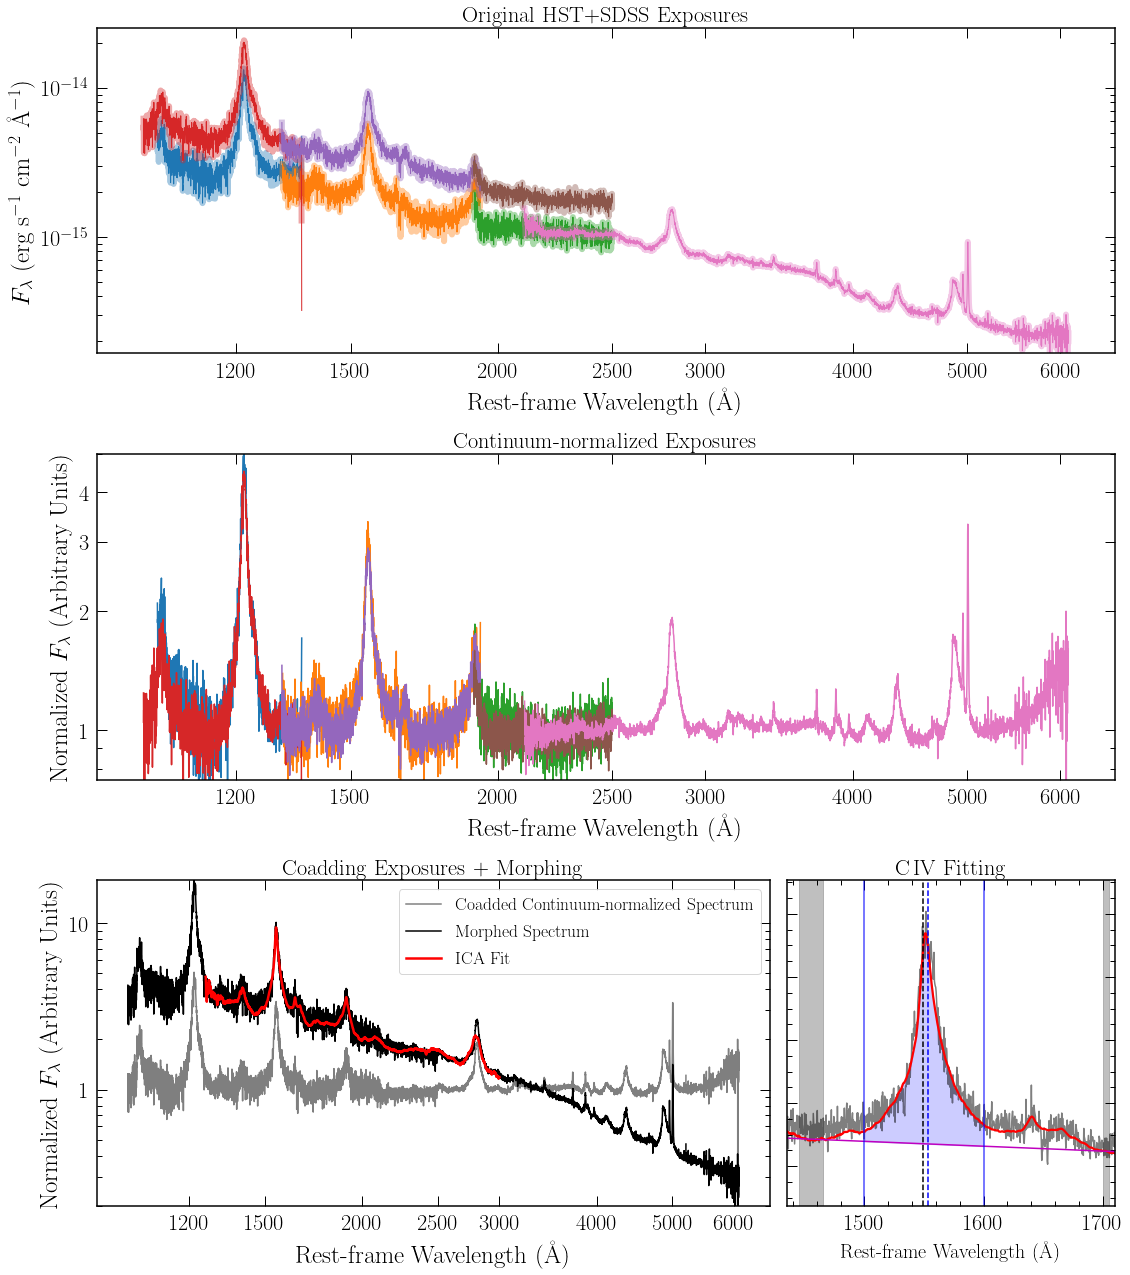

In [535]:
#fig, [axRebin, axNorm, axMorph] = plt.subplots(3, 1, figsize=(16,17))
fig = plt.figure(figsize=(16,18), constrained_layout=True)
gs  = GridSpec(12, 12, figure=fig)
axRebin = fig.add_subplot(gs[:4,:]) #ica reconstruction
axNorm  = fig.add_subplot(gs[4:8,:])   #CIV fitting
axMorph = fig.add_subplot(gs[8:,:8])
axCIV   = fig.add_subplot(gs[8:,8:])
#plt.subplots_adjust(vspace=0)

#do re-bin
ylow, yup = np.nanpercentile(fluxes_rebin, [0.05,100])
for i in range(Nexp):
    p = axRebin.plot(waves[i,:]/(1+zem), fluxes[i,:], alpha=0.4, lw=6)
    axRebin.plot(10.**loglam_rebin[i,:]/(1+zem), fluxes_rebin[i,:], color=p[0].get_color(), lw=1)
    #axRebin.plot(10.**loglam_rebin[i,:]/(1+zem), errors_rebin[i,:], color=p[0].get_color(), lw=0.75)
    axNorm.plot(10.**loglam_rebin[i,:]/(1+zem), fluxes_rebin_contnorm[i,:], color=p[0].get_color())

#axRebin.plot(spec_wave/(1+zem), spec_flux, "-b")
axRebin.set_ylim(ylow, yup+5e-15)
#axRebin.set_ylim(2e-17, yup)
axRebin.set_yscale("log")
axRebin.set_xscale("log")
set_logxticks(axRebin, waves[waves!=0]/(1+zem))
axRebin.set_xlabel("Rest-frame Wavelength (Å)", fontsize=25)
axRebin.set_ylabel(r"$F_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)", fontsize=25)

#axNorm.plot(coadd_wave/(1+zem), coadd_flux, "-k", lw=0.65)
axNorm.set_ylim(0.75,5)
axNorm.set_yscale("log")
axNorm.set_yticks([1,2,3,4])
axNorm.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axNorm.set_xscale("log")
set_logxticks(axNorm, waves[waves!=0]/(1+zem))
axNorm.set_xlim(axRebin.get_xlim())
axNorm.set_ylabel(r"Normalized $F_{\lambda}$ (Arbitrary Units)", fontsize=25)
axNorm.set_xlabel("Rest-frame Wavelength (Å)", fontsize=25)

#morph flux
flux_coadd_morph, _ = spec_morph.morph2(coadd_wave, coadd_flux, coadd_errs, zem, "Identifier")
axMorph.plot(coadd_wave/(1+zem), coadd_flux, "-k", alpha=0.5, label="Coadded Continuum-normalized Spectrum")
axMorph.plot(coadd_wave/(1+zem), flux_coadd_morph, "-k", label="Morphed Spectrum")
axMorph.plot(wave_ica, flux_ica, "-r", lw=2.5, label="ICA Fit")
axMorph.set_ylim(0.2,18)
axMorph.set_yscale("log")
axMorph.set_yticks([1,10])
axMorph.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axMorph.set_xscale("log")
set_logxticks(axMorph, waves[waves!=0]/(1+zem))
axMorph.set_xlim(axRebin.get_xlim())
axMorph.set_xlabel("Rest-frame Wavelength (Å)", fontsize=25)
axMorph.set_ylabel(r"Normalized $F_{\lambda}$ (Arbitrary Units)", fontsize=25)
axMorph.legend(loc="upper right", prop={"size":17.5})

get_CIV(coadd_wave/(1+zem), flux_coadd_morph, wave_ica, flux_ica, "", ax=axCIV)

"""
plot_wmask(axICA, wave_arb, flux_arb, mask_arb)
#axICA.plot(wave_arb, errs_arb, "-k", alpha=0.4)
axICA.plot(wave_ica, flux_ica, "-r")
axICA.set_ylim(0.2,15)
axICA.set_yscale("log")
axMorph.set_yticks([1,10])
axMorph.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axMorph.set_xscale("log")
set_logxticks(axMorph, waves[waves!=0]/(1+zem))
axMorph.set_xlim(axRebin.get_xlim())
axMorph.set_ylabel(r"Normalized $F_{\lambda}$ (Arbitrary Units)", fontsize=25)
"""

axRebin.tick_params(labelsize=22.5)
axNorm.tick_params(labelsize=22.5)
axMorph.tick_params(labelsize=22.5)
axCIV.tick_params(labelsize=22.5)

axRebin.set_title("Original HST+SDSS Exposures", fontsize=22.5)
axNorm.set_title("Continuum-normalized Exposures", fontsize=22.5)
axMorph.set_title("Coadding Exposures + Morphing", fontsize=22.5)
axCIV.set_title("C\,IV Fitting", fontsize=22.5)

plt.tight_layout()
plt.savefig("/Users/trevormccaffrey/Dropbox/HST/final_MarchApril2023/examples_fullprocess_J09270.pdf")
plt.show()

In [536]:
!ls /Users/trevormccaffrey/Dropbox/HST/final_MarchApril2023

HST_CIV_Sulentic2007_HSLA2018_finalprops.csv
ICA_reconstructions_final_March2023
examples_fullprocess_J09270.pdf
plots


In [446]:
axRebin.get_xlim(), axNorm.get_xlim()

((914.6631338110885, 6669.176265776984),
 (746.5467981812401, 6346.838759689058))

In [236]:
(mask_arb>0).sum(), (mask_arb==1).sum(), (mask_arb==2).sum(), (mask_arb==3).sum(), len(mask_arb)

(1313, 0, 1313, 0, 4781)

In [276]:
var = 1
var == var

True

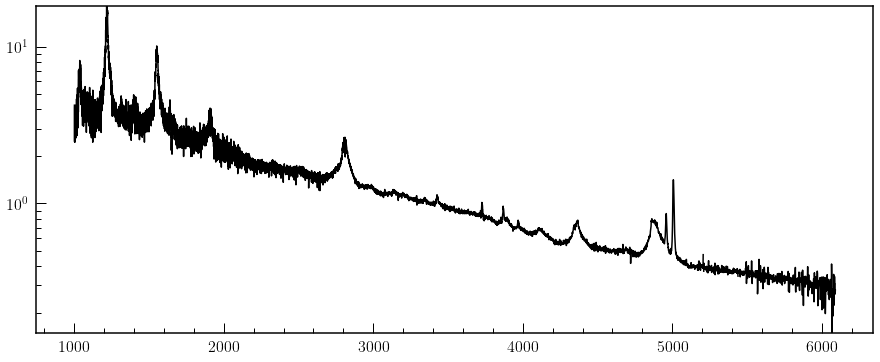

In [394]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))

iplot_start = 0
#iplot_end   = 0
mask_curr   = mask_arb[0]
for i in range(len(wave_arb)):
    #go until mask is a different value
    if mask_arb[i]!=mask_curr or i==len(wave_arb)-1:
        if mask_curr==3:
            #plot BAL region
            ax.plot(wave_arb[iplot_start:i], flux_arb[iplot_start:i], "-m", zorder=2)
        elif mask_curr==2:
            #plot NAL region
            ax.plot(wave_arb[iplot_start:i], flux_arb[iplot_start:i], "-y", zorder=2)
        elif mask_curr==1:
            #plot badpix region
            ax.plot(wave_arb[iplot_start:i], flux_arb[iplot_start:i], "-r", zorder=2)
        else:
            #plot BAL region
            ax.plot(wave_arb[iplot_start:i], flux_arb[iplot_start:i], "-k", zorder=1)
        
        mask_curr = mask_arb[i]
        iplot_start = i-1

    
ax.set_ylim(.15,18)
ax.set_yscale("log")    
plt.show()

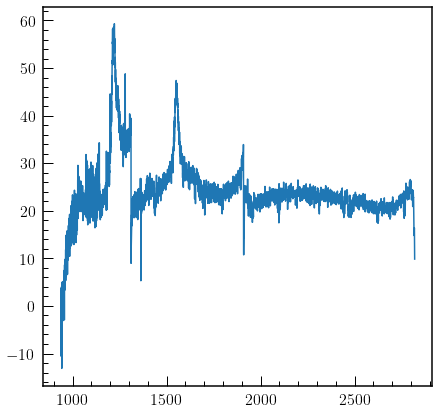

In [255]:
plt.plot(wave_arb, flux_arb/errs_arb)

In [5]:
#print(os.path.abspath())
print(os.path.join('.'))
print(os.path.abspath(os.path.join('.')))

.
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code


In [6]:
os.path.abspath(os.path.join('.'))+"\\ICA Scripts"

'C:\\Users\\Alexandros Pratsos\\PycharmProjects\\Summer 2024\\Richards\\Trevor Code\\ICA Scripts'

In [10]:
os.path.abspath(os.path.join("ICA Scripts"))

'C:\\Users\\Alexandros Pratsos\\PycharmProjects\\Summer 2024\\Richards\\Trevor Code\\ICA Scripts'

In [3]:
sys.path.append(os.path.abspath(os.path.join("test_folder")))

In [2]:
sys.path

['C:\\Users\\Alexandros Pratsos\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip',
 'C:\\Users\\Alexandros Pratsos\\AppData\\Local\\Programs\\Python\\Python311\\DLLs',
 'C:\\Users\\Alexandros Pratsos\\AppData\\Local\\Programs\\Python\\Python311\\Lib',
 'C:\\Users\\Alexandros Pratsos\\AppData\\Local\\Programs\\Python\\Python311',
 '',
 'C:\\Users\\Alexandros Pratsos\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages',
 'C:\\Users\\Alexandros Pratsos\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\win32',
 'C:\\Users\\Alexandros Pratsos\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\win32\\lib',
 'C:\\Users\\Alexandros Pratsos\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\Pythonwin',
 'C:\\Users\\Alexandros Pratsos\\PycharmProjects\\Summer 2024\\Richards\\Trevor Code\\ICA Scripts',
 '/Users/Trevor1/Dropbox/ICA_module/code_main/',
 '/Users/Trevor1/Dropbox/HST/HSTCode/',
 '/Users/Trevor1/Dropbox/HST/HSTCode/'

In [4]:
import test_pratsos 

In [6]:
test_pratsos.test_func()

foo


In [10]:
test  = np.zeros((2, 3))
test

array([[0., 0., 0.],
       [0., 0., 0.]])

In [12]:
loglam_temp       = np.arange(np.log10(1000), np.log10(10000), 0.0001)
loglam_temp_edges = loglam_temp - 0.0001/2
loglam_temp_edges = np.append(loglam_temp_edges, loglam_temp[-1]+0.0001/2)

In [17]:
print(loglam_temp)
print(loglam_temp_edges)

[3.     3.0001 3.0002 ... 3.9997 3.9998 3.9999]
[2.99995 3.00005 3.00015 ... 3.99975 3.99985 3.99995]


In [20]:
a = np.array([1, 2, 3])
b = np.array([a] * 3)
b

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

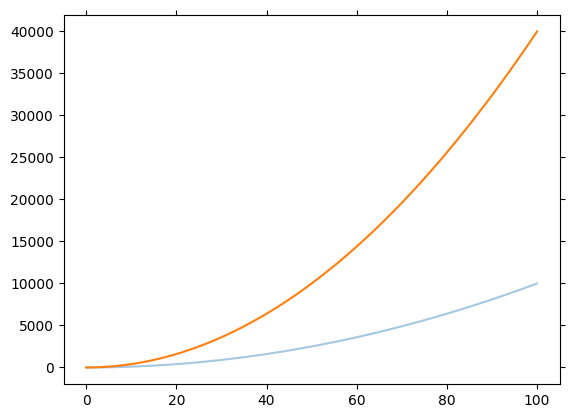

In [51]:
def f(x):
    return x * x
x = np.arange(0, 101, 1)
fig, ax = plt.subplots()
a = ax.plot(x, f(x), alpha = 0.4)
ax.plot(x, f(2*x))
#b = ax.plot(x, f(2 * x))
#c = ax.plot(x, f(3 * x))

In [46]:
print((a))

In [42]:
a[0]

In [22]:
Nexp

7

In [44]:
wave = fits.open('J09270+3902/y0pe0702t/y0pe0702t_c0f.fits')[0].data

In [45]:
print(wave)

[[2311.7195 2311.3613 2311.003  ... 1572.6458 1572.2854 1571.9249]
 [2311.7195 2311.3613 2311.003  ... 1572.6458 1572.2854 1571.9249]
 [2311.7195 2311.3613 2311.003  ... 1572.6458 1572.2854 1571.9249]
 ...
 [2311.7195 2311.3613 2311.003  ... 1572.6458 1572.2854 1571.9249]
 [2311.7195 2311.3613 2311.003  ... 1572.6458 1572.2854 1571.9249]
 [2311.7195 2311.3613 2311.003  ... 1572.6458 1572.2854 1571.9249]]


In [55]:
wave[-1]

array([2311.7195, 2311.3613, 2311.003 , ..., 1572.6458, 1572.2854,
       1571.9249], dtype='>f4')

In [56]:
ind = -1
nzero = (wave[ind]>0.)

In [62]:
10.**loglam_temp

array([ 1697.17419434,  1697.56502813,  1697.95595193, ...,
       10323.48710557, 10325.86445001, 10328.24234192])